## EECS 491 Assignment 4

Due Sat Apr 25 before midnight. 100 points total.

### Submitting assignments to Canvas

- For jupyter notebooks, submit the .ipynb file and a pdf export of the notebook.
- Make sure you check that the pdf export represents the latest state of your notebook and that the equations and figures are properly rendered.

- If your are not using notebooks, writeup your assignment using latex and submit a pdf with your code.  The writeup should include relevant code with description if it can fit on a page.  

- Use the following format for filenames:
  - `EECS491-A4-yourcaseid.ipynb`
  - `EECS491-A4-yourcaseid.pdf`

- If you have more than these two files, put any additional files in a directory named `EECS491-A4-yourcaseid`. Do not include binaries or large data files. Then zip this directory and submit it with the name `EECS491-A4-yourcaseid.zip`.  Do not use other compression formats.  The `.ipynb` file can be included in the zipped directory, but make sure you submit the `.pdf` file along with the `.zip` file.  This is so it appears at the top level on canvas, which allows for easier grading.

### Exercise 1. Multivariate Gaussians (10 points)

1.1 (5 pts) Consider the 2D normal distribution

$$ p(x,y) \sim \mathcal{N}(\mathbf{\mu}, \mathbf{\Sigma}) $$

Define three separate 2D covariance matrices $\mathbf{\Sigma}$ for each of the following cases: $x$ and $y$ are uncorrelated; $x$ and $y$ are correlated; and $x$ and $y$ are anti-correlated.  Plot samples from these distributions to show these properties.  Use a different mean for each.  Make sure your plots show the density. 

1.2 (5 pts) Compute the principal axes for each of these distributions, i.e. the eigenvectors of the covariance matrices.  Use can use a linear algebra package. Plot the samples again, but this time overlay the 1, 2, and 3-sigma contours and with the scaled eigenvectors.

In [424]:
import matplotlib.pyplot as plt
from numpy import linalg as LA
import numpy as np
import csv
from scipy import stats
from copy import copy, deepcopy
from sklearn.preprocessing import normalize
import random
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from mpl_toolkits import mplot3d

In [429]:
#x and y are uncorrelated
cov1 = [[1, 0], [0, 1]] 
#x and y are correlated
cov2 = [[1, -.8], [-.8, 1]]  
#x and y are anti correlated
cov3 = [[1, .9], [.9, 1]] #anti-correlated
mean1 = [2, 2]
mean2 = [0, 0]
mean3 = [1, 1]

values1, vectors1 = LA.eig(cov1)
print(values1[0],", ",values1[1])
print(vectors1[:,0],", ",vectors1[:,1])
values2, vectors2 = LA.eig(cov2)
print(values2[0],", ",values2[1])
print(vectors2[:,0],", ",vectors2[:,1])
values3, vectors3 = LA.eig(cov3)
print(values3[0],", ",values3[1])
print(vectors3[:,0],", ",vectors3[:,1])

1.0 ,  1.0
[1. 0.] ,  [0. 1.]
1.7999999999999998 ,  0.19999999999999973
[ 0.70710678 -0.70710678] ,  [0.70710678 0.70710678]
1.9 ,  0.09999999999999976
[0.70710678 0.70710678] ,  [-0.70710678  0.70710678]


In [425]:
sigma1,sigma2,sigma3 = stats.chi2.ppf(0.683, 2), chi2.ppf(0.955,2), chi2.ppf(0.997,2)

def drawEigArrows(cov,mean):        
    values1,vectors = LA.eig(cov)
    values = np.sqrt(values1)
    for i in [sigma1,sigma2,sigma3]:
        plt.annotate(s='', xy=(mean), xytext=(mean[0]+vectors[:,0][0]*values[0]*i,mean[1]+vectors[:,0][1]*values[0]*i), arrowprops=dict(arrowstyle='<-',color='r'))
        plt.annotate(s='', xy=(mean), xytext=(mean[0]+vectors[:,1][0]*values[1]*i,mean[1]+vectors[:,1][1]*values[1]*i), arrowprops=dict(arrowstyle='<-',color='r'))

def threeSigma(cov, mean):
    values, vectors = LA.eig(cov)
    
    t = np.linspace(0, 2*np.pi, 100)
    ellipse = [np.cos(t), np.sin(t)]
    
    for i in [sigma1,sigma2,sigma3]:
        ellipsePlot = i * vectors.dot(np.diag(np.sqrt(values)).dot(ellipse)).T + mean
        plt.plot(ellipsePlot[:,0], ellipsePlot[:,1])

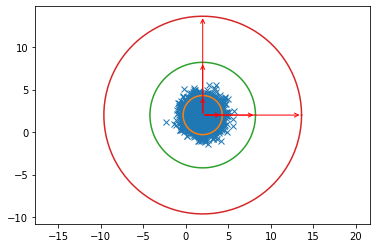

In [426]:
x, y = np.random.multivariate_normal(mean1, cov1, 5000).T
plt.plot(x, y, 'x')
threeSigma(cov1,mean1)
drawEigArrows(cov1,mean1)
plt.axis('equal');
plt.show()

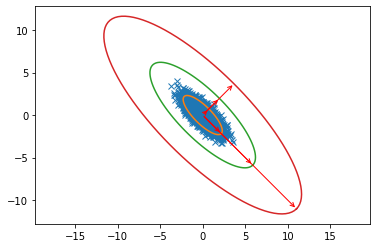

In [407]:
x, y = np.random.multivariate_normal(mean2, cov2, 5000).T
plt.plot(x, y, 'x')
threeSigma(cov2,mean2)
drawEigArrows(cov2,mean2)
plt.axis("equal")
plt.show()

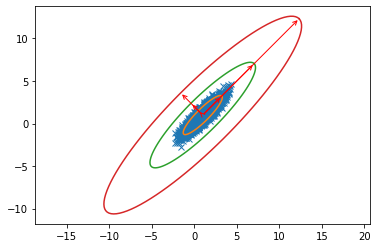

In [210]:
x, y = np.random.multivariate_normal(mean3, cov3, 5000).T
plt.plot(x, y, 'x')
threeSigma(cov3,mean3)
drawEigArrows(cov3,mean3)
plt.axis("equal")
plt.show()

### Exercise 2. Linear Gaussian Models (20 pts)

Consider two independent multi-dimensional Gaussian random vector variables
$
\newcommand{\bx}{\mathbf{x}}
\newcommand{\bz}{\mathbf{z}}
\newcommand{\by}{\mathbf{y}}
\newcommand{\bm}{\mathbf{m}}
\newcommand{\mbmu}{\mathbf{\mu}} % don't collide with \bm
\newcommand{\bS}{\mathbf{\Sigma}}
\newcommand{\bA}{\mathbf{A}}
\newcommand{\bB}{\mathbf{B}}
\newcommand{\bc}{\mathbf{c}}
\newcommand{\N}{\mathcal{N}}
$

$$
\begin{eqnarray}
p(\bx) &=& \mathcal{N}(\bx | \mbmu_x, \bS_x) \\
p(\bz) &=& \mathcal{N}(\bz | \mbmu_z, \bS_z)
\end{eqnarray}
$$

Now consider a third variable that is the sum of the first two:

$$
\by = \bx + \bz
$$

2.1 (5 pts) What is the expression for the distribution $p(\by)$?

Given the characteristic function of multivariate gaussian:
$$\phi_{x}(u)=exp(iu'\mu_x-u'\Sigma_xu)$$
$$\phi_{x+z}(u)=exp(iu'\mu_x-u' \Sigma_x u)exp(iu'\mu_z-u'\Sigma_zu) = exp(iu'\mu_x-u' \Sigma_x u + iu'\mu_z-u'\Sigma_zu) = exp(iu'(\mu_X+\mu_z)-u'(\Sigma_x+\Sigma_z)u)$$
Which indicates the expression for a distribution $p(x+z)$ is equivalent to simply $\N(\mu_x+\mu_z,\Sigma_x+\Sigma_z)$

2.2 (5 pts) What is the expression for the condidtional distribution $p(\by|\bx)$?

$$p(y|x) = \frac{p(y,x)}{p(x)}$$
And given that

$$\phi_{x}(u)=exp(iu'\mu_x-u'\Sigma_xu)$$
$$\phi_{x,y}(u)/\phi_y(u)=exp([iu'(\mu_{x,x+z}-u'\Sigma_{x,x+z}u]-[iu'\mu_x+u'\Sigma_xu])=exp(iu'(\mu_{x,x+z}-\mu_x)-u'(\Sigma_x,x+z+\Sigma_x)u)$$
$$\N(\mu_{x,x+z}-\mu_x,\Sigma_{x,x+z}+\Sigma_x)$$



2.3 (10 pts) Write code to illustrate the result in Q2.1. Show both the components of $\by = \bx + \bz$ and that the sampling from the analytic result is the same as adding two samples.

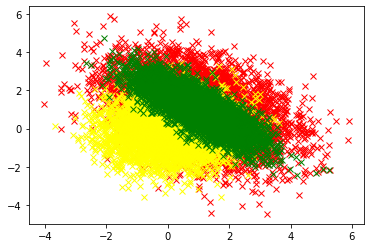

In [331]:
np.random.seed(5)
mean1 = [0, 0]
mean2 = [1, 1]
cov1 = [[1, 0], [0, 1]] 
cov2 = [[1, -.8], [-.8, 1]]  

x3, y3 = np.random.multivariate_normal(np.array(mean2)+np.array(mean1), np.array(cov2)+np.array(cov1), 5000).T
plt.plot(x3, y3, 'x', color = "red") #y = x + z
x1, y1 = np.random.multivariate_normal(mean1, cov1, 5000).T
plt.plot(x1, y1, 'x', color = "yellow") #x
x2, y2 = np.random.multivariate_normal(mean2, cov2, 5000).T
plt.plot(x2, y2, 'x', color = "green") #z

In [334]:
stats.ks_2samp(x1+x2, x3).pvalue,stats.ks_2samp(y1+y2, y3).pvalue
#the two p values are both higher than 50% indicating that the two samples are identical

(0.5936767491197451, 0.49623226435327117)

### Exercise 3. Dimensionality Reduction and PCA (25 pts)

In this quesiton you will use principal component analysis to reduce the dimensionality of your data and analyze the results.

3.1 (5 pts) Find a set of high dimensional data.  It should be continuous and have at least 6 dimensions, e.g. stats for sports teams, small sound segments or images patches also work.  Note that if the dimensionality of the data is too large, you might run into computational efficiency problems using standard methods.  Describe the data and illustrate it, if appropriate.

3.2 (5 pts) Compute the principal components of the data.  Plot a few of the largest eigenvectors and interpret them in terms of how there are modeling the structure of the data.

The eigenvectors represent the variation along that principal component.  The magnitude of the eigenvector represents the magnitude of the variation.  Clearly the largest eigenvector is significantly higher than the second largest eigenvector.  This means there is strong variance in only one principal component.

3.3 (5 pts) Plot, in decreasing order, the cumulative percentage of variance each eigenvector accounts for as a function of the eigenvector number.  These values should be in decreasing order of the eigenvalues. Interpret these results.

3.4 (10 pts) Plot the original data projected into the space of the two principal eigenvectors (i.e. the eigenvectors with the largest two eigenvalues).  Be sure to either plot relative to the mean, or subtract the mean when you do this.  Interpret your results.  What insights can you draw?  Interpret the dimensions of the two largest principal components.  Which dimensions of the data are correlated?  Or anti-correlated?

# Exercise 3: Answers

The dataset depicts goalie stats for games played in the NHL.  Dimensions are: "game_id","player_id","team_id","timeOnIce","assists","goals","pim","shots","saves","powerPlaySaves","shortHandedSaves","evenSaves","shortHandedShotsAgainst","evenShotsAgainst","powerPlayShotsAgainst","decision","savePercentage","powerPlaySavePercentage","evenStrengthSavePercentage".  
Note these states are for a single game and are not lifetime stats.  I converted W/L to binary and deleted every row which containd "N/A" items.  I also deleted columns containing id numbers.

One eigenvector is extremely large and the other is very small in comparison.  This means there is lots of variation in one direction but very litle in every other.  Therefore, thre is one correlation trend in the data.  This seems logical as a goalie with good stats in one area will likey have good stats in other areas as well, i.e. it is rare for a goalie to have amazing saves and poor performance in passing for example (I don't know anything about hockey) and vice versa. 

The two largest principal components are positively correlated.  There are three clear groups of positive correlation between component one and two.  This means there are multiple positively correlated trends in the original data.  Looking at the data this checks out since many attributes are either directly or indirectly correlated.  For example, "saves" is directly correlated to "savePercentage" and "saves" is also indirectly correlated to "decision" (win/loss). The variation is actually so one dimensional that this could be plotted on a single axis.  Goalies who "save" more, have a higher save percentage, other stats related to saves are higher, and they also win more.  Thre is very minimal amount of data that deviates from this trend.

In [414]:
np.set_printoptions(suppress=True)
data = []
read = list(csv.reader(open("game_goalie_stats.csv")))
for i in read:
    data.append(i)
data = np.array(data)
data = data[1:]
for i in range(len(data[:,15])):
    if data[i,15] == "W":
        data[i,15] = 1
    else:
        data[i,15] = 0
newData = []
for i in data:
    if "NA" not in i:
        newData.append(i)
data = np.array(newData)[:,2:].astype(np.float)

sorted eigenvalues by cumsum
[[     0.99743074 360052.48973344]
 [     0.99892648    539.9321831 ]
 [     0.99934068    149.51954468]
 [     0.99973728    143.16477659]
 [     0.99991683     64.81344171]
 [     0.99998062     23.02654236]
 [     0.99999049      3.5618447 ]
 [     0.99999728      2.45063526]
 [     0.99999844      0.41911812]
 [     0.99999911      0.24492527]
 [     0.99999955      0.15755627]
 [     0.99999984      0.10363959]
 [     0.99999994      0.03640695]
 [     1.              0.02186042]
 [     1.              0.00013495]
 [     1.              0.00002244]
 [     1.             -0.        ]]
principal component one
360052.48973343946
[-0.00012194  0.99984886  0.00000848  0.00000006  0.00000668  0.0079707
  0.00798448  0.00089253  0.00018591  0.006906    0.00018355  0.00695271
  0.00083444  0.00023889  0.00458999  0.00630778  0.00405516]
principal component two
539.9321830976061
[ 0.00006742  0.00781568 -0.00004826 -0.00000147  0.00013552 -0.03735298
 -0.058333

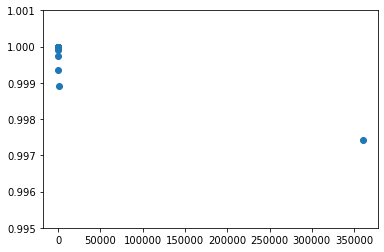

In [416]:
cov = np.cov(data.T)
w,v = LA.eig(cov)

sortedEigValues = np.array([[0.0,0.0]] * len(w))
for index, i in enumerate(w):
    sortedEigValues[index][0] = i/np.sum(np.diag(cov))
    sortedEigValues[index][1] = i
sortedEigValues = np.flip(sortedEigValues[np.argsort(sortedEigValues[:, 0])],0)
cumsum = 0
for index, i in enumerate(sortedEigValues):
    sortedEigValues[index][0] += cumsum
    cumsum = sortedEigValues[index][0]
print("sorted eigenvalues by cumsum")
print(sortedEigValues)
print("principal component one")
print(str(sortedEigValues[0,1]))
print(v[:,np.argwhere(w==sortedEigValues[0,1])[0][0]])
print("principal component two")
print(str(sortedEigValues[1,1]))
print(v[:,np.argwhere(w==sortedEigValues[1,1])[0][0]])
plt.scatter(sortedEigValues.T[1],sortedEigValues.T[0])
plt.ylim(.995,1.001)
plt.show()

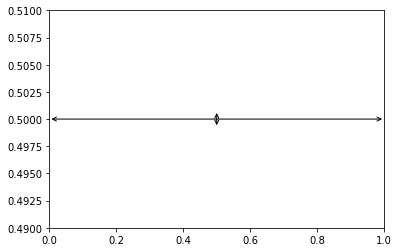

In [28]:
x = [sortedEigValues[0,1],sortedEigValues[1,1]]
n = x / np.linalg.norm(x)
plt.annotate(s='', xy=(n[0]*0.5+0.5,0.5), xytext=(n[0]*-0.5+0.5,0.5), arrowprops=dict(arrowstyle='<->'))
plt.annotate(s='', xy=(0.5,n[1]*0.5+0.5), xytext=(0.5,n[1]*-0.5+0.5), arrowprops=dict(arrowstyle='<->'))
plt.ylim((0.49,0.51))

plt.show()

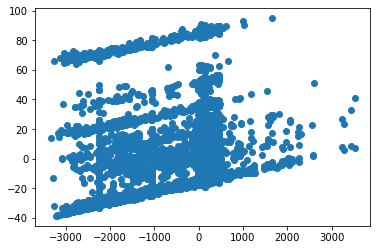

In [423]:
def doPCA(dat, n):
    mean = np.mean(dat.T, axis=1)
    centered = data - mean
    cov = np.cov(data.T)
    values, vectors = LA.eig(cov)
    P = vectors.T[:2].dot(centered.T)
    plt.scatter(P[0],P[1])
doPCA(data,2)

### Exercise 4. Gaussian Mixture Models (25 pts)

4.1 (10 pts) Use the EM equations for multivariate Gaussian mixture model to write a program that implements the Gaussian Mixture Model to estimates from an ensemble of data the means, covariance matrices, and class probabilities.  Choose reasonable values for your initial values and a reasonable stopping criterion.  Explain your code and the steps of the algorithm.  Do not assume a diagonal or isotropic covariance matrices.

4.2 (5 pts) Write code to plot the 3-sigma contours of each Gaussian overlayed on the data (try to find a library function to plot ellipses).  Illustrate with an example.

4.3 (5 pts) Define a two-model Gaussian mixture test case, synthesize the data, and verify that your algorithm infers the (approximately) correct values based on training data sampled from the model and plotting the results.

4.4 (5 pts) Apply your model to the Old Faithful dataset (supplied with the assignment files).  Run the algorithm for the cases $K=1$, $K=2$, and $K=3$.  For each case, plot the progression of the solutions at the beginning, middle, and final steps in the learning.  For each your plots (you should have 9 total), you should also print out the corresponding values of the mean, covariance, and class probabilities.

The EM equation works by estimating the fit of a gaussian fit on our data set repeatedly until convergence.  Here's the equation for expectation (all equations taken from the slides in L19):

Determing likelihood of class c given data x is:

$$p_{k,n}=p(c_k|x^n,\theta_{1:K}) = \frac{p(c_k)p(x^n|c_k,\theta_k)}{\sum_kp(c_k)p(x^n|c_k,\theta_k)}$$
And using our knowledge of the normal distribution this equals:
$$\frac{p(c_k)\N(x_n|\theta_k)}{\sum_kp(c_k)\N(x_n|\theta_k)}$$

For maximization we want to maximize parameters $\mu_k,\Sigma_k,\pi_k$ with respect to $p(x)$ where $\pi_k$ simply represents $p(c_k)$.  In other words, the mean, covariance, and prior.
Taking the log likelihood gives:
$$log\,p(x|\theta,\Sigma,\pi)=\sum_{n=1}^N{\sum_{k=1}^K\pi_k\N(x_n|\mu_k,\Sigma_k)}$$
Taking the derivative with respect to each parameter and setting to zero allows us to maximize.  We now have.
$$\mu_k=\frac{1}{N_k}\sum_{n=1}^Np(n,k)x_n$$
$$\Sigma_k = \frac{1}{N_k}\Sigma_{n=1}^Np(n,k)(x_n-\mu_k)(x_n-\mu_k)^T$$


In [428]:
def expectation(data, model):
    #we're gonna build a posterior with size NxK
    probs = []
    for n in range(len(data)):
        #iterate through all data points and find p(n,k) for each
        #start a new array for this data point
        r = []
        #Calculate the likelihood that each class k is responsible for generating data x
        #do this by iterating through all classes k
        for k in range(len(model)):
            #find the current parameters
            prior,mean,covar = model[k]['prior'],model[k]['mean'],model[k]['covariance']
            #use multivariate normal to generate the probability
            #multiply by the parameter pi -- the prior, or probability of a point being in classs k
            r.append(stats.multivariate_normal.pdf(data[n], mean = mean, cov = covar)*prior)

        #normalize the probs to a value between 0 and 1
        probs.append(r/np.sum(r))
        
    #we need to finish by dividing by the summation term in the expectation expression
    #sum each probability along axis 0 to get sum_k
    probs = probs/np.sum(probs,0)        
    return probs

def maximization(posterior, data, model):
    #start with an empty array for the new parameters
    newModel = []
    #we need to modify each parameter for each class
    #for each class in the mixture
    for k in range(len(model)):
        #fill empty matrices
        newMean, newCov, newPrior = np.zeros((2)), np.zeros((2,2)), 0
    
        #find the "new" prior
        #sum p_n,k for class k and divide the result by N
        newPrior = np.sum(posterior,0)[k]/len(data)    
        
        #find the new mean
        for n in range(len(data)):
            #we're iterating through the data points
            #remember that we multiple p_n,k by the data point
            newMean += posterior[n][k] * data[n]

        #now that we have the new mean we can find the covariance
        for n in range(len(data)):
            #iterating through the data points again
            #remember that we need x_n - mu_k and (x_n - mu_k).T
            subtractMean = (data[n] - newMean)[np.newaxis]
            subtractMeanT = subtractMean.T
            #and then multiply by p_n,k
            newCov += posterior[n][k] * subtractMean * subtractMeanT
        
        #add the new parameters for the current class
        newModel.append({'mean': newMean, 'covariance': newCov, 'prior': newPrior})
        
    return newModel

#a method for checking for convergence
def checkConverge(newModel,currentModel):
    totalDiff = 0.0
    for i in range(len(newModel)):
        oldCov, oldMean = currentModel[i]['covariance'],currentModel[i]['mean']
        newCov, newMean = newModel[i]['covariance'],newModel[i]['mean']
        totalDiff+= LA.norm(oldCov-newCov)+LA.norm(oldMean-newMean)
    return totalDiff

#and do the em cycle 
#this is pretty simple, calculate the posterior, then increment the parameters
#do it until the model converges
def findEM(data, currentModel):
    plt.subplot(1,3,1)
    plt.plot(data[0],data[1],'x')
    for k in range(len(currentModel)):
        threeSigma(currentModel[k]['covariance'],currentModel[k]['mean'])
    print("beginning parameters")
    print(currentModel)
    posterior = expectation(data.T,currentModel)
    newModel = maximization(posterior,data.T,currentModel)
    difference = checkConverge(newModel,currentModel)
    halfway = (difference-1.0)/2.0
    halfwayPlotted = False 
    currentModel = copy.deepcopy(newModel)
    #stop when the parameters stop changing greatly
    while difference > 1:
        if difference < halfway and not halfwayPlotted:
            plt.subplot(1,3,2)
            plt.plot(data[0],data[1],'x')
            for k in range(len(currentModel)):
                threeSigma(currentModel[k]['covariance'],currentModel[k]['mean'])
            print("intermediary parameters")
            print(currentModel)
            halfwayPlotted = True
        posterior = expectation(data.T,currentModel)
        newModel = maximization(posterior,data.T,currentModel)
        difference = checkConverge(newModel,currentModel)
        currentModel = copy.deepcopy(newModel)
    #draw the sigma contours
    plt.subplot(1,3,3)
    plt.plot(data[0],data[1],'x')
    for k in range(len(currentModel)):
        threeSigma(currentModel[k]['covariance'],currentModel[k]['mean'])
    print("final parameters")
    print(currentModel)
    return currentModel

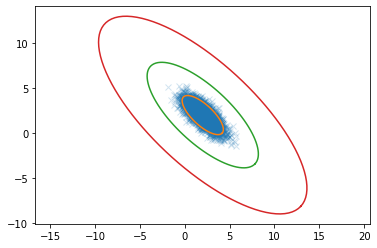

In [394]:
mean = [2, 2]
cov = [[1, -.7], [-.7, .9]]  #correlated

x, y = np.random.multivariate_normal(mean, cov, 5000).T
plt.plot(x, y, 'x',alpha=0.2)

#I defined this function in the third cell of the notebook
threeSigma(cov, mean)
plt.axis('equal');

beginning parameters
[{'mean': array([5., 5.]), 'covariance': array([[1., 0.],
       [0., 1.]]), 'prior': 0.5}, {'mean': array([6., 6.]), 'covariance': array([[1., 0.],
       [0., 1.]]), 'prior': 0.5}]
final parameters
[{'mean': array([2.2738, 1.8494]), 'covariance': array([[0.76609156, 0.14836428],
       [0.14836428, 1.05592964]]), 'prior': 0.010000000000000004}, {'mean': array([10.0488,  9.951 ]), 'covariance': array([[0.81130656, 0.1548932 ],
       [0.1548932 , 0.940941  ]]), 'prior': 0.010000000000000007}]
[[1, 0], [0, 1]] [2, 2]
[[1, 0], [0, 1]] [10, 10]


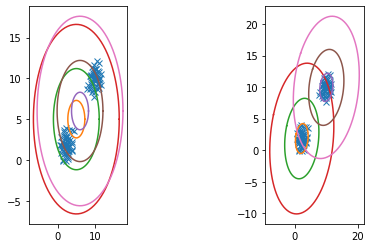

In [389]:
#we need to define a starting point
means = np.asarray([[5.0, 5.0], [6.0, 6.0]])
covs = np.asarray([[[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]]])

model = [{'mean': means[0], 'covariance':covs[0], 'prior': 0.5},{'mean': means[1], 'covariance':covs[1], 'prior': 0.5}]

#synthesize some data
cov1 = [[1, 0], [0, 1]]  
mean1 = [2, 2]
x1, y1 = np.random.multivariate_normal(mean1, cov1, 50).T

cov2 = [[1, 0], [0, 1]]  
mean2 = [10, 10]
x2, y2 = np.random.multivariate_normal(mean2, cov2, 50).T

X = np.append(x1,x2),np.append(y1,y2)
data = np.round(np.array(X).T,2).T

test = copy.deepcopy(model)
findEM(data,test)
print(cov1,mean1)
print(cov2,mean2)
#they should be reasonably close

In [390]:
f = open('faithful.txt', 'r')
x = f.readlines()
data = None
for i in range(len(x)):
    x[i] = x[i].split(" ")
    x[i][1] = x[i][1].rstrip()
    data = copy.deepcopy(x)
    data = np.array(data)
f.close()
data  = np.array(data).astype(float).T

#we need to define a starting point 
means = np.asarray([[6.0, 60.0], [3.0, 70.0], [3.0, 80.0]])
covs = np.asarray([[[1.0, 0.0], [0.0, 3.0]], [[0.5, 0.2], [0.2, 0.6]], [[1.0, 0], [0,3.0]]])
model1 = [{'mean': means[0], 'covariance':covs[0], 'prior': 1.0}]
model2 = [{'mean': means[0], 'covariance':covs[0], 'prior': 0.5},{'mean': means[1], 'covariance':covs[1], 'prior': 0.5}]
model3 = [{'mean': means[0], 'covariance':covs[0], 'prior': 1.0/3},{'mean': means[1], 'covariance':covs[1], 'prior': 1.0/3},{'mean': means[2], 'covariance':covs[2], 'prior': 1.0/3}]


beginning parameters
[{'mean': array([ 6., 60.]), 'covariance': array([[1., 0.],
       [0., 3.]]), 'prior': 1.0}]
final parameters
[{'mean': array([ 3.48778309, 70.89705882]), 'covariance': array([[  1.29793889,  13.92641885],
       [ 13.92641885, 184.14381488]]), 'prior': 0.003676470588235294}]


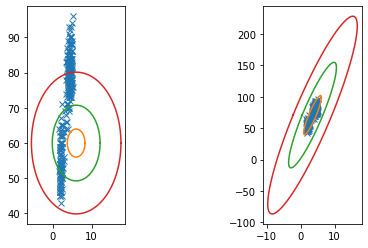

In [391]:
a=findEM(data,model1) #i think this one converges in one step and that's why there's no intermediary plot

beginning parameters
[{'mean': array([ 6., 60.]), 'covariance': array([[1., 0.],
       [0., 3.]]), 'prior': 0.5}, {'mean': array([ 3., 70.]), 'covariance': array([[0.5, 0.2],
       [0.2, 0.6]]), 'prior': 0.5}]
intermediary parameters
[{'mean': array([ 3.15844735, 68.84233572]), 'covariance': array([[  1.35186442,  16.63424992],
       [ 16.63424992, 235.79252323]]), 'prior': 0.0036764705882353014}, {'mean': array([ 4.34316056, 76.23375225]), 'covariance': array([[ 0.14450216,  0.57096932],
       [ 0.57096932, 10.55187842]]), 'prior': 0.0036764705882352967}]
final parameters
[{'mean': array([ 2.03828145, 54.49930088]), 'covariance': array([[ 0.07074154,  0.45329105],
       [ 0.45329105, 33.8517184 ]]), 'prior': 0.0036764705882352967}, {'mean': array([ 4.29124411, 79.98636165]), 'covariance': array([[ 0.16800863,  0.91673478],
       [ 0.91673478, 35.79134514]]), 'prior': 0.0036764705882353006}]


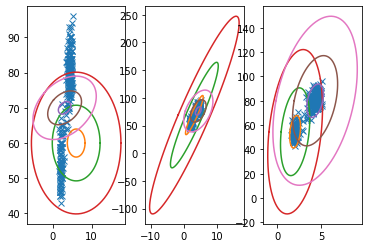

In [392]:
a=findEM(data,model2)

beginning parameters
[{'mean': array([ 6., 60.]), 'covariance': array([[1., 0.],
       [0., 3.]]), 'prior': 0.3333333333333333}, {'mean': array([ 3., 70.]), 'covariance': array([[0.5, 0.2],
       [0.2, 0.6]]), 'prior': 0.3333333333333333}, {'mean': array([ 3., 80.]), 'covariance': array([[1., 0.],
       [0., 3.]]), 'prior': 0.3333333333333333}]
intermediary parameters
[{'mean': array([ 2.06165971, 54.61508093]), 'covariance': array([[ 0.10271609,  0.68349148],
       [ 0.68349148, 34.31358777]]), 'prior': 0.35576599437554185}, {'mean': array([ 3.89700568, 70.93156635]), 'covariance': array([[0.28061135, 0.74234152],
       [0.74234152, 4.73187351]]), 'prior': 0.10530295207734257}, {'mean': array([ 4.33383437, 81.0128038 ]), 'covariance': array([[ 0.1445907 ,  0.46339015],
       [ 0.46339015, 27.83165061]]), 'prior': 0.5389310535471156}]
final parameters
[{'mean': array([ 2.02922055, 54.40504045]), 'covariance': array([[ 0.06372448,  0.37828812],
       [ 0.37828812, 33.33130655]]),

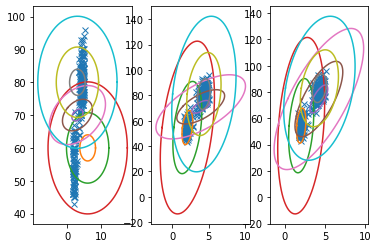

In [383]:
a=findEM(data,model3)

### Exploration (20 points)

Like in previous assignments, in this exercise you have more lattiude and are meant to do creative exploration.  The intention is for you to teach yourself about a topic beyond what's been covered above.  Please consult the rubric below for what is expected.

# Exponential Distributions

An exponential distribution can be generally expressed as:

$$p(x|\theta)=h(x)exp(\sum_i\eta_i(\theta)T_i(x)-\psi(\theta))$$
$\theta$ are parameters, $T_i(x)$ are test statistics, and $\psi(\theta)$ is the log partition function below:
$$\psi(\theta)=log \int_x h(x)exp(\sum_i\eta_i(\theta)T_i(x)) $$

A brief explanation.  The log partition factor is the log of a normalization factor which reduces the integral of the distribution to one, which is necessary for $f(x;\theta)$ to be a distribution. $T_i(x)$ is also known as the sufficient statistic, and represents information that x gives about $\theta$.  The sufficient statistic ensures that for two data sets x and y:
$$\frac{f(x;\theta_1)}{f(x;\theta_2)}=\frac{(y;\theta_1)}{f(y;\theta_2)}$$
The log partition function is especially important because the sufficient statistics can be derived using it.  For example in a gamma distribution defined by $f(x;\alpha,\beta)=\frac{\beta^\alpha x^{\alpha-1}e^{-\beta x}}{\Gamma(\alpha)}$ one of the sufficient parameters is $log(x)$ which can be derived using cumulative moment generating function, $K(u|\eta)=A(\eta+u)-A(\eta)$.
<br>

$\eta$ is also known as the natural parameter.  It restricts $f_X(x;\theta)$ to finite values using the values of $\eta$ in natural parameter space.  

Returning to the general form of an exponential distribution, another form when $\eta(\theta) = 0$ is :
$$p(x|\theta)=h(x)exp(\theta^TT(x)-\psi(\theta))$$


<br>a gaussian can be transformed into the general formula.

$$f(x)=\frac{1}{\sqrt{2\pi\sigma^2}}exp(-\frac{1}{2\sigma^2}(x-\mu)^2) = exp(-\frac{1}{2\sigma^2}x^2+\frac{\mu}{\sigma^2}x-\frac{\mu^2}{2\sigma^2}-0.5log2\pi\sigma^2)$$
$$t_1(x)=x,t_2(x) = -\frac{x^2}{2},\theta_1=\mu,\theta_2=\sigma^2,h(x)=1,\eta_1(\theta)=\frac{\theta_1}{\theta_2}$$
<br>
Scaling $T_i(x)$ and $\eta_i$ inversely will give the same result. i.e. this will also give the univariate gaussian distribution:
$$t_1(x)=2x,t_2(x) = -\frac{2x^2}{2},\theta_1=\mu,\theta_2=\sigma^2,h(x)=1,\eta_1(\theta)=\frac{\theta_1}{2\theta_2}$$
<br>

Exponential distributions are very useful because they have conjugate priors.  If the prior distribution is the same kind, then the prior is called a conjugate prior.  Which leads us to learning distributions.  

# Maximum Likelihood Regression

For a distribution $p(x|\theta)$ with parameter $\theta$ and data $x$, determine the parameter $\theta$ that best exhibits $x$.  One such method is maximum likelihood, or:

$$\theta^{ML}=argmax_\theta p(\chi|\theta)$$

The maximum likelihood is a problem of hypothesis and not one of probability.  We are making a hypothesis about the distribution of the data.  A hypothesis is neither exhaustive nor mutually exclusive.  That is, there are an infinite level of hypotheses, and a hypotheses can contain other hypotheses.  In accordance $p(x|y) = p(y|x)/p(y) = likelihood(y|x)$

So now a hypothesis of parameter $\theta$ regarding data X is $$L(\theta|X)=p(\theta|x_1,x_2,...,x_n)=p(\theta|x_1)p(\theta|x_2)...p(\theta|x_n)=\prod p(x_i|\theta)$$ And since we're maximizing this likelihood, $$\max_\theta (\sum_iln(p(x_i|\theta))$$

Here's how to avoid simpson's paradox and correctly fit data with an unmeasured confounder.  Take for example a set of data of height and weight, within this data are men and women, but the data does not measure the subjects gender.

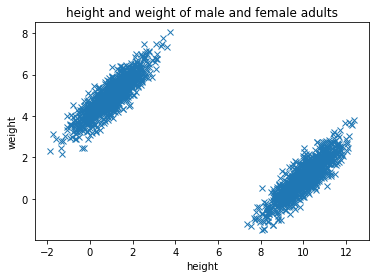

In [318]:
mean = [1, 5]
cov = [[0.8, 0.7], [0.7, 0.8]] #anti-correlated
x1, y1 = np.random.multivariate_normal(mean, cov, 1000).T

mean = [10, 1]
cov = [[0.8, 0.7], [0.7, 0.8]] #anti-correlated
x2, y2 = np.random.multivariate_normal(mean, cov, 1000).T

data=[np.append(x1,x2),np.append(y1,y2)]

plt.plot(data[0],data[1], 'x')
plt.xlabel("height")
plt.ylabel("weight")
plt.title("height and weight of male and female adults")
plt.show()

Here's a bad way to fit the data.

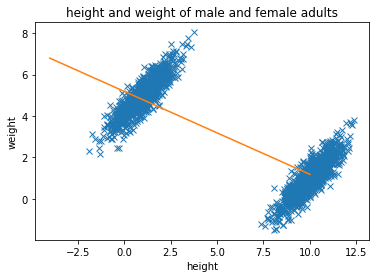

In [319]:
mlr = LinearRegression()
twoDArr=np.vstack((data[0],np.zeros(len(data[0])))).T
mlr.fit(twoDArr,data[1])

t = np.linspace(-4,10,100)
linfit = t*mlr.coef_[0]+mlr.intercept_

plt.plot(data[0],data[1], 'x')
plt.plot(t,linfit)
plt.xlabel("height")
plt.ylabel("weight")
plt.title("height and weight of male and female adults")
plt.show()

So let's use gaussian mixtures to seperate these two classes.

beginning parameters
[{'mean': array([5., 5.]), 'covariance': array([[0.5, 0. ],
       [0. , 1. ]]), 'prior': 0.5}, {'mean': array([6., 6.]), 'covariance': array([[1., 0.],
       [0., 1.]]), 'prior': 0.5}]
intermediary parameters
[{'mean': array([1.69227819, 5.30497636]), 'covariance': array([[ 1.76930622, -0.8677597 ],
       [-0.8677597 ,  1.58310013]]), 'prior': 0.333848743321897}, {'mean': array([6.49849308, 2.37521894]), 'covariance': array([[21.05696824, -7.38331103],
       [-7.38331103,  3.87179018]]), 'prior': 0.6661512566781028}]
final parameters
[{'mean': array([1.01136061, 4.99797254]), 'covariance': array([[0.75162598, 0.6618874 ],
       [0.6618874 , 0.76505354]]), 'prior': 0.5}, {'mean': array([9.97665141, 0.9770895 ]), 'covariance': array([[0.74951608, 0.66346406],
       [0.66346406, 0.77611497]]), 'prior': 0.5}]


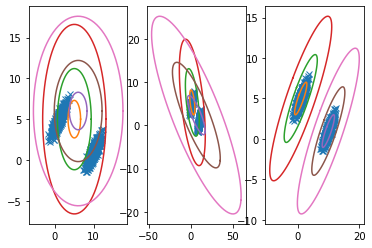

In [320]:
means = np.asarray([[5.0, 5.0], [6.0, 6.0]])
covs = np.asarray([[[0.5, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]]])

model2 = [{'mean': means[0], 'covariance':covs[0], 'prior': 0.5},{'mean': means[1], 'covariance':covs[1], 'prior': 0.5}]
data = np.array([np.append(x1,x2),np.append(y1,y2)])

gausMix = findEM(data,model2)

And create a new feature for gender.

In [321]:
normal1 = multivariate_normal.pdf(data.T, mean=gausMix[0]['mean'],cov=gausMix[0]['covariance'])
normal2 = multivariate_normal.pdf(data.T, mean=gausMix[1]['mean'],cov=gausMix[1]['covariance'])
confounder = []
for i in range(len(normal1)):
    if normal1[i] > normal2[i]:
        confounder.append(1)
    else:
        confounder.append(2)
confounder = np.array(confounder)

we now have a 3rd set of feature's giving each subjects gender. 

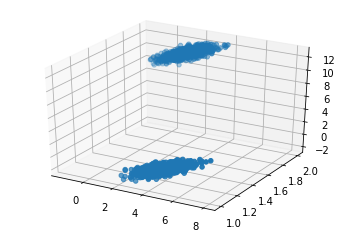

In [322]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(data[1],confounder,data[0])

Now that we have two features and one outcome, how can the effect of a single measure be found?  For example if I want to find the effect of weight on height.  One way is simply stratifying on gender, and finding causality in both stratifications.  Here's what this would look like:

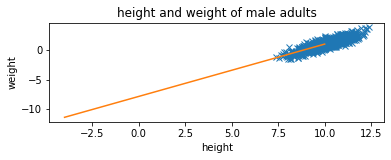

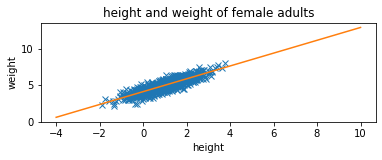

In [323]:
women = data.T[confounder == 1].T
men = data.T[confounder == 2].T

mlr = LinearRegression()
twoDArr=np.vstack((men[0],np.zeros(len(men[0])))).T
mlr.fit(twoDArr,men[1])

t = np.linspace(-4,10,100)
linfit1 = t*mlr.coef_[0]+mlr.intercept_

mlr = LinearRegression()
twoDArr=np.vstack((women[0],np.zeros(len(women[0])))).T
mlr.fit(twoDArr,women[1])

linfit2 = t*mlr.coef_[0]+mlr.intercept_

plt.subplot(211)
plt.plot(men[0],men[1], 'x')
plt.plot(t,linfit1)
plt.xlabel("height")
plt.ylabel("weight")
plt.title("height and weight of male adults")
plt.show()

plt.subplot(212)
plt.plot(women[0],women[1], 'x')
plt.plot(t,linfit2)
plt.xlabel("height")
plt.ylabel("weight")
plt.title("height and weight of female adults")
plt.show()

Or we could use IP weighting to adjust for the "confounding" from the gender feature.  To do this we fit a linear model to estimate $Pr[height|gender]$ for all data.  Then, for each data point take $\frac{1}{Pr[height|gender]}$ and use these values as weights for another linear model where we fit $E[weight|height]$, weighting each point accordingly.  Here's how that's done:

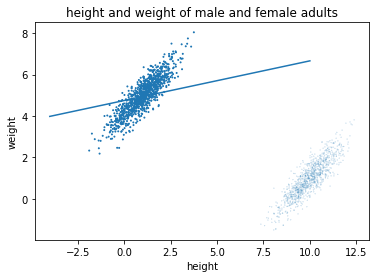

In [329]:
mlr = LinearRegression()
twoDArr=np.vstack((confounder,np.zeros(len(confounder)))).T
mlr.fit(twoDArr,data[0])
#since confounder is a binary value and our data is limited, i exaggerated the weights
Wa = (1/(mlr.coef_[0]*confounder+mlr.intercept_))**2

mlr = LinearRegression()
twoDArr=np.vstack((data[0],np.zeros(len(data[0])))).T
mlr.fit(twoDArr,data[1], sample_weight=Wa)

t = np.linspace(-4,10,100)
linfit3 = t*mlr.coef_[0]+mlr.intercept_
plt.scatter(data[0],data[1], s=Wa)
plt.plot(t,linfit3)
plt.xlabel("height")
plt.ylabel("weight")
plt.title("height and weight of male and female adults")
plt.show()

And clearly this is a more accurate result than the naive likelihood estimate.

Source: causal learning 442 with prof podgurski

#### Exploration Grading Rubric

Exploration problems will be graded according the elements in the table below.  The scores in the column headers indicate the number of points possible for each rubric element (given in the rows).  A score of zero for an element is possible if it is missing entirely.

|     | Substandard (+1) | Basic (+2) | Good (+3) | Excellent (+5) |
| :-- | :----------- | :---- | :--- | :-------- |
| <b> Pedagogical Value </b> | No clear statement of idea or concept being explored or explained; lack of motivating questions. | Simple problem with adequate motivation; still could be a useful addition to an assignment. | Good choice of problem with effective illustrations of concept(s).  Demonstrates a deeper level of understanding. | Problem also illustrates or clarifies common conceptual difficulties or misconceptions. |
| <b> Novelty of Ideas </b> | Copies existing problem or makes only a trivial modification; lack of citation(s) for source of inspiration. | Concepts are similar to those covered in the assignment but with some modifications of an existing exericse. | Ideas have clear pedagogical motivation; creates different type of problem or exercise to explore related or foundational concepts more deeply. | Applies a technique or explores concept not covered in the assignment or not discussed at length in lecture. | 
| <b> Clarity of Explanation </b> | Little or confusing explanation; figures lack labels or useful captions; no explanation of motivations. | Explanations are present, but unclear, unfocused, wordy or contain too much technical detail. | Clear and concise explanations of key ideas and motivations. | Also clear and concise, but includes illustrative figures; could be read and understood by students from a variety of backgrounds. |
| <b> Depth of Exploration </b> | Content is obvious or closely imitates assignment problems. | Uses existing problem for different data. | Applies a variation of a technique to solve a problem with an interesting motivation; explores a concept in a series of related problems. | Applies several concepts or techniques; has clear focus of inquiry that is approached from multiple directions.|